In [102]:
num_workers = 2
num_clients = 2

client_starts = []
client_durations = []
for _ in range(num_clients):
  client_starts.append([])
  client_durations.append([])

for i in range(num_workers):
  with open('results/results_' + str(i) + '.txt', 'r') as file:
    # Iterate over each line in the file
    execution_order = [int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]]
    for j in range(num_clients):
      client_durations[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])
    for j in range(num_clients):
      client_starts[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])
      # print(f'Starts: {client_starts[j]}')

absolute_start = min(client_starts[0] + client_starts[1])
for i in range(len(client_starts)):
  client_durations[i] = [y for _, y in sorted(zip(client_starts[i], client_durations[i]))]
  client_starts[i] = sorted(client_starts[i])
  client_starts[i] = [start - absolute_start for start in client_starts[i]]

[595442861, 597592935, 595991721, 596795618, 597593805, 598479085]
[1046935, 797175, 803889, 798183, 885274, 948223]

[595442861, 595991721, 596795618, 597592935, 597593805, 598479085]
[1046935, 803889, 798183, 797175, 885274, 948223]


In [86]:

interval_seconds = 1

def chunk(starts):
  chunked_starts = [0]
  time_interval = interval_seconds * 1000000
  cur_time = -1
  for i in range(len(starts)):
    start = starts[i]
    if start > cur_time + time_interval:
      while start > cur_time + time_interval:
        chunked_starts.append(0)
        cur_time += time_interval
      chunked_starts[-1] = 1
    else:
      chunked_starts[-1] += 1
  return chunked_starts

client1_chunked_starts = chunk(client_starts[0])
client2_chunked_starts = chunk(client_starts[1])
print(client1_chunked_starts)
print(client2_chunked_starts)

# disk,cpu - 1,4 - 3,1 - out of 9/18
client1_disk_util = [100 * 1/9 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]
client1_cpu_util = [100 * 4/18 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]

client2_disk_util = [100 * 3/9 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]
client2_cpu_util = [100 * 1/18 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]

[2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 3, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3]
[1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 1]


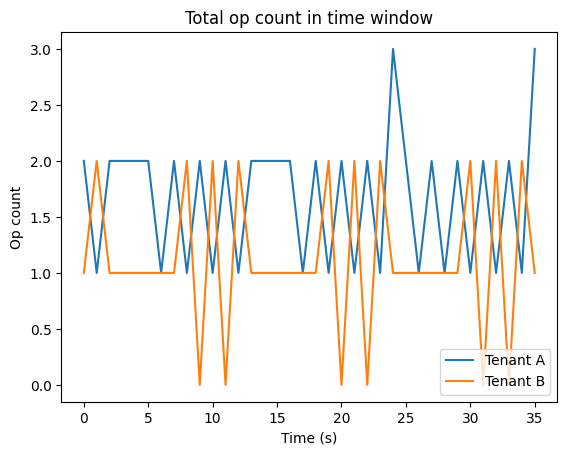

In [87]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('Total op count in time window')
ax.set_ylabel('Op count')
ax.set_xlabel('Time (s)')
# ax.set_ylim(0,100)

ax.plot(list(range(len(client1_chunked_starts))), client1_chunked_starts, label='Tenant A')
ax.plot(list(range(len(client2_chunked_starts))), client2_chunked_starts, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

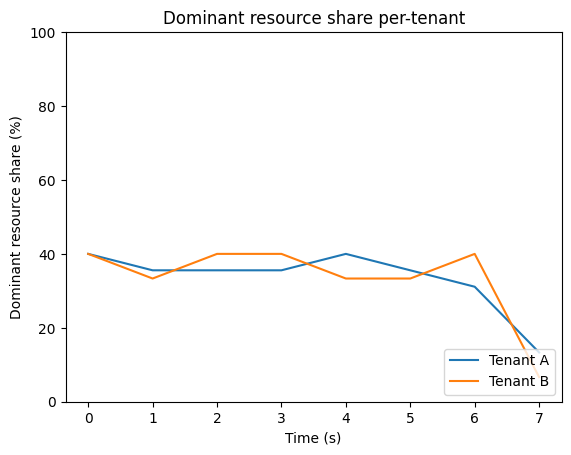

In [78]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('Dominant resource share per-tenant')
ax.set_ylabel('Dominant resource share (%)')
ax.set_xlabel('Time (s)')
ax.set_ylim(0,100)

# how_many = 30
# how_many = len(client1)
# x_axis = list(range(how_many))
# x_axis = [x * 3 for x in list(range(how_many))]

ax.plot(list(range(len(client1_cpu_util))), client1_cpu_util, label='Tenant A')
ax.plot(list(range(len(client2_disk_util))), client2_disk_util, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

In [ ]:
# Metrics:
# Dominant resource share over time

In [69]:
# Per-client QPS
for i in range(len(client_starts)):
  starts = client_starts[i]
  run_start = starts[0]
  run_end = starts[-1] + client_durations[i][-1]
  qpus = len(starts) / (run_end - run_start)
  qps = qpus * 1000000
  print(f'Client {i} QPS = {qps}')

Client 0 QPS = 1.6335916540891453
Client 1 QPS = 1.0995303383647934


In [75]:
# Total system utilization
# CPU: total compute time used / total time of experiment * 2 CPUs
cpu_usage = 0
cpu_usage += 2/3 * len(client_starts[0])  # 2/3s compute/query
cpu_usage += 1/6 * len(client_starts[1])  # 1/6s compute/query

disk_usage = 0
disk_usage += 1/3 * len(client_starts[0])  # 1/3GB read/query
disk_usage += 1 * len(client_starts[1])  # 1GB read/query

run_duration_us = max(client_starts[0][-1] + client_durations[0][-1], client_starts[1][-1] + client_durations[1][-1])
run_duration_s = run_duration_us / 1000000

cpu_util = cpu_usage / (run_duration_s * 2)  # 2 cores
print(f'CPU util: {cpu_util}')

disk_util = disk_usage / (run_duration_s * 3)  # 3GB/s 
print(f'Disk util: {disk_util}')


CPU util: 0.6352849167995932
Disk util: 0.5445299286853656


In [91]:
# Dominant resource share over time
# 1. every Xs, how many ongoing ops are there? multiple this by resource usage and determine dominant share
# 2. sliding window of Xs, how may resources were used in this interval?

# 1
# for each client
# 
# let's say every 100ms
interval_us = 100000  # 100ms
num_interval = 370  # duration of experiment
intervals_us = [interval_us * t for t in range(1,num_interval)]
client_counts = []
for i in range(len(client_starts)):
  client_counts.append([0] * len(list(range(1, num_interval))))

for i in range(len(intervals_us)):
  t = intervals_us[i]
  # find all the ops that were ongoing at this point in time
  for j in range(len(client_starts)):
    starts = client_starts[j]
    durs = client_durations[j]
    # print(len(starts), len(durs))
    for k in range(len(starts)):
      start = starts[k]
      dur = durs[k]
      if start > t:
        break
      if start + dur < t:
        continue
      if start <= t and start + dur > t:
        client_counts[j][i] += 1

for counts in client_counts:
  print(counts)







60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 29
40 21
60 2

IndexError: list index out of range